In [2]:
import pandas as pd


In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/SreeSajeev/FakeNewsDetector/refs/heads/main/news.csv')


In [5]:
print(df.head())
print(df.info())


   Unnamed: 0                                              title  \
0        8476                       You Can Smell Hillary’s Fear   
1       10294  Watch The Exact Moment Paul Ryan Committed Pol...   
2        3608        Kerry to go to Paris in gesture of sympathy   
3       10142  Bernie supporters on Twitter erupt in anger ag...   
4         875   The Battle of New York: Why This Primary Matters   

                                                text label  
0  Daniel Greenfield, a Shillman Journalism Fello...  FAKE  
1  Google Pinterest Digg Linkedin Reddit Stumbleu...  FAKE  
2  U.S. Secretary of State John F. Kerry said Mon...  REAL  
3  — Kaydee King (@KaydeeKing) November 9, 2016 T...  FAKE  
4  It's primary day in New York and front-runners...  REAL  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6335 non-null   int64 

In [6]:
import pandas as pd
import numpy as np
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:

# Drop Unnamed column if present
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

In [8]:
# Merge title + text into full_text
df['full_text'] = df['title'].fillna('') + ' ' + df['text'].fillna('')

In [9]:

# Preview
print(df[['title', 'text', 'label']].head())

                                               title  \
0                       You Can Smell Hillary’s Fear   
1  Watch The Exact Moment Paul Ryan Committed Pol...   
2        Kerry to go to Paris in gesture of sympathy   
3  Bernie supporters on Twitter erupt in anger ag...   
4   The Battle of New York: Why This Primary Matters   

                                                text label  
0  Daniel Greenfield, a Shillman Journalism Fello...  FAKE  
1  Google Pinterest Digg Linkedin Reddit Stumbleu...  FAKE  
2  U.S. Secretary of State John F. Kerry said Mon...  REAL  
3  — Kaydee King (@KaydeeKing) November 9, 2016 T...  FAKE  
4  It's primary day in New York and front-runners...  REAL  


In [10]:
def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation and non-alphabetic characters
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['clean_text'] = df['full_text'].apply(clean_text)


In [11]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

df['clean_text'] = df['clean_text'].apply(remove_stopwords)


In [12]:
# If not already binary: 'FAKE' → 0, 'REAL' → 1
df['label'] = df['label'].map({'FAKE': 0, 'REAL': 1})


In [13]:
print(df[['clean_text', 'label']].head())
print(df['label'].value_counts())  # Check balance


                                          clean_text  label
0  smell hillarys fear daniel greenfield shillman...      0
1  watch exact moment paul ryan committed politic...      0
2  kerry go paris gesture sympathy us secretary s...      1
3  bernie supporters twitter erupt anger dnc trie...      0
4  battle new york primary matters primary day ne...      1
label
1    3171
0    3164
Name: count, dtype: int64


In [14]:
#Train a baseline model using TF-IDF + Logistic Regression
#Train-Test Split
from sklearn.model_selection import train_test_split

X = df['clean_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)


In [15]:
#TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [16]:
#Train a Classifier (Logistic Regression)

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9194948697711128
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92       633
           1       0.94      0.90      0.92       634

    accuracy                           0.92      1267
   macro avg       0.92      0.92      0.92      1267
weighted avg       0.92      0.92      0.92      1267



In [18]:
## Get top contributing words
feature_names = tfidf.get_feature_names_out()
coefficients = model.coef_[0]

top_fake = np.argsort(coefficients)[-10:]
top_real = np.argsort(coefficients)[:10]

print("🔴 Top 'FAKE' indicators:")
for i in top_fake:
    print(f"{feature_names[i]}: {coefficients[i]:.4f}")

print("\n🟢 Top 'REAL' indicators:")
for i in top_real:
    print(f"{feature_names[i]}: {coefficients[i]:.4f}")


🔴 Top 'FAKE' indicators:
fox: 2.0676
islamic: 2.1220
state: 2.1244
debate: 2.2987
president: 2.3135
sanders: 2.4158
candidates: 2.5348
cruz: 2.6974
gop: 2.7603
said: 6.5657

🟢 Top 'REAL' indicators:
october: -4.5846
hillary: -3.8740
election: -2.8191
november: -2.8144
article: -2.4693
share: -2.4429
source: -2.2534
fbi: -2.2327
russia: -2.2177
wikileaks: -1.9616


In [19]:
#Create a Prediction + Explanation Function
import numpy as np

def explain_prediction(text, model, vectorizer, top_n=10):
    # Vectorize the input text
    vec = vectorizer.transform([text])
    prediction = model.predict(vec)[0]
    proba = model.predict_proba(vec)[0]

    # Get feature importance
    feature_names = vectorizer.get_feature_names_out()
    coefs = model.coef_[0]

    # Multiply TF-IDF weights by model coefficients
    scores = vec.toarray()[0] * coefs
    word_score_pairs = [
        (feature_names[i], scores[i])
        for i in range(len(scores)) if scores[i] != 0
    ]

    word_score_pairs.sort(key=lambda x: abs(x[1]), reverse=True)
    top_words = word_score_pairs[:top_n]

    return {
        'prediction': prediction,
        'confidence': round(np.max(proba), 2),
        'top_words': top_words
    }


In [20]:
sample_text = "Hillary Clinton was under FBI investigation during the elections."
result = explain_prediction(sample_text, model, tfidf)

print(f"Prediction: {result['prediction']} ({result['confidence'] * 100:.2f}%)")
print("Top Influential Words:")
for word, score in result['top_words']:
    print(f"{word}: {score:.4f}")


Prediction: 0 (99.00%)
Top Influential Words:
hillary: -1.2341
fbi: -1.1699
investigation: -0.4690
elections: -0.3324
clinton: 0.0928


#Dynamic Misinformation Narrative Tracking & Visualization

In [21]:
# Install all required libraries
!pip install pandas numpy spacy scikit-learn plotly pyvis \
            sentence-transformers yake networkx \
            transformers shap matplotlib

# Download spaCy English model
!python -m spacy download en_core_web_sm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [22]:
import pandas as pd
import numpy as np
import spacy
import sklearn
import plotly
import pyvis
from sentence_transformers import SentenceTransformer
import yake
import networkx as nx
from transformers import pipeline
import shap
import matplotlib.pyplot as plt


In [23]:
nlp = spacy.load("en_core_web_sm")


In [25]:
texts = df['text'].dropna().tolist()
processed_docs = list(nlp.pipe((text.lower() for text in texts), batch_size=50, n_process=-1))

In [26]:
import yake

kw_extractor = yake.KeywordExtractor(top=10, lan="en", n=1)
keywords = [kw_extractor.extract_keywords(text) for text in texts]

In [28]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(texts, show_progress_bar=True)


Batches:   0%|          | 0/198 [00:00<?, ?it/s]

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(embeddings, df['label'], test_size=0.2)
clf = RandomForestClassifier()
clf.fit(X_train, y_train)


RandomForestClassifier()

<Figure size 640x480 with 0 Axes>

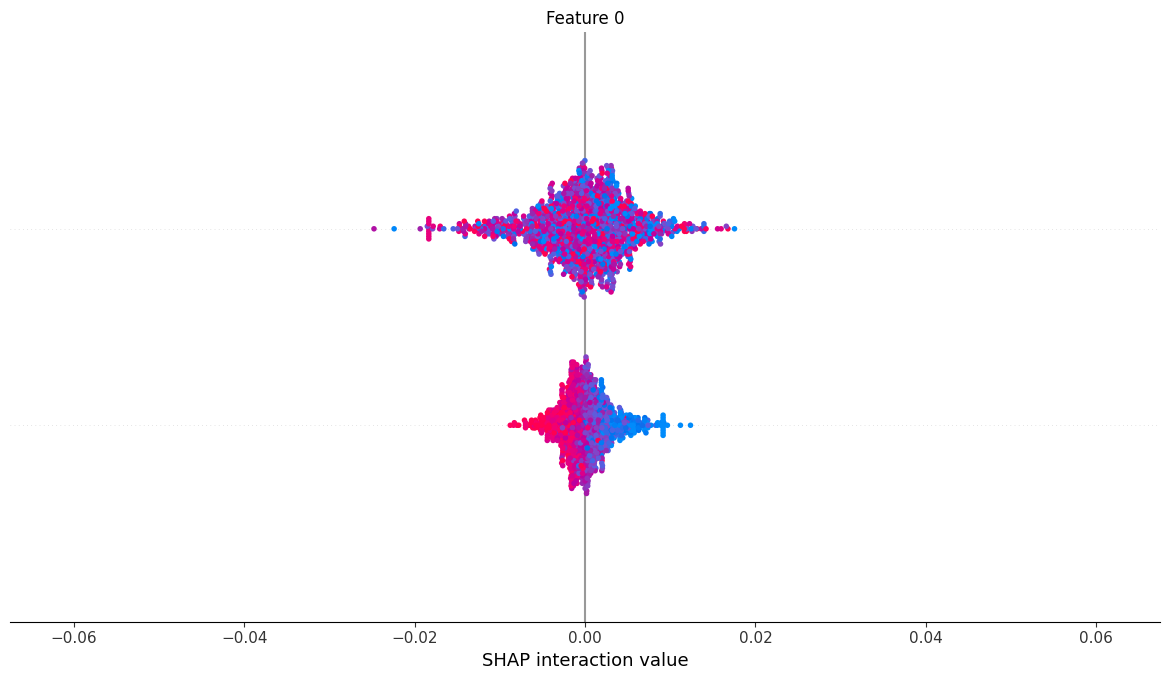

In [30]:
import shap

explainer = shap.Explainer(clf)
shap_values = explainer(X_test)

# Visualize
shap.summary_plot(shap_values, features=X_test)


In [31]:
from pyvis.network import Network
import networkx as nx
import numpy as np
from pyvis.network import Network
import networkx as nx
import numpy as np
